In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [36]:
# Explore the tables with inspector
inspector = inspect (engine)
col_1 = inspector.get_columns('measurement')
col_2 = inspector.get_columns('station')
print('Measurement Table:')
for column in col_1:
    print(column['name'], column['type'])
print('-------------------------')
print('Station Table:')
for column in col_2:
    print(column['name'], column['type'])

Measurement Table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-------------------------
Station Table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
print("Measurement:")
engine.execute('SELECT * FROM measurement ORDER BY date DESC LIMIT 10').fetchall()

Measurement:


[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0),
 (12186, 'USC00519523', '2017-08-22', 0.0, 82.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (2722, 'USC00519397', '2017-08-21', 0.0, 81.0),
 (7634, 'USC00514830', '2017-08-21', 0.02, 79.0),
 (12185, 'USC00519523', '2017-08-21', None, 82.0)]

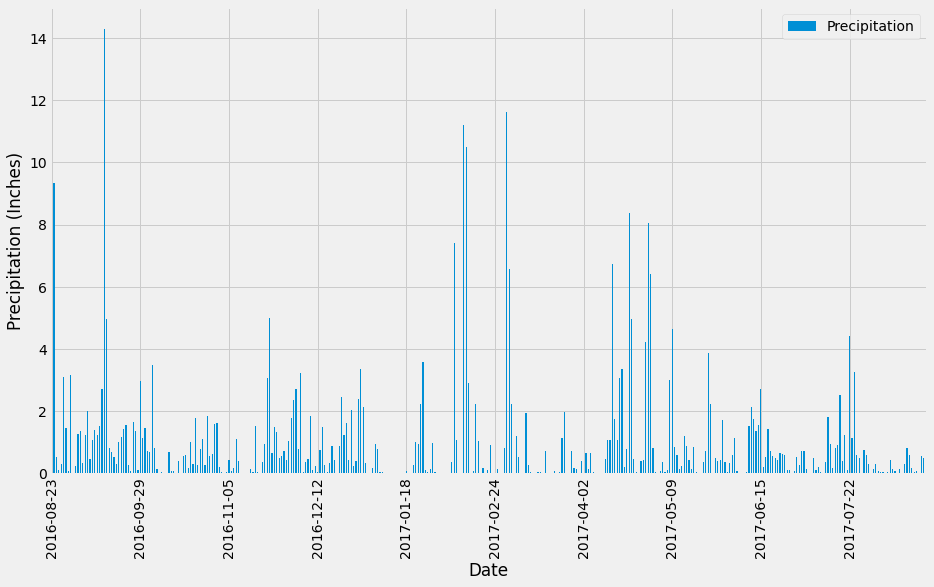

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
sel = [Measurement.date,Measurement.prcp]

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year_prcp = session.query(*sel).filter\
(func.strftime(Measurement.date) >= one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_year_prcp, columns = ['date','prcp'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.groupby('date')
prcp_sum = df['prcp'].sum()
df = pd.DataFrame({'Precipitation':prcp_sum})

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar(figsize = (14,8))
plt.locator_params(axis="x", nbins=10)
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date")
plt.show()



In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sel = [Measurement.date,Measurement.prcp]
last_year_prcp = session.query(*sel).filter\
(func.strftime(Measurement.date) > one_year_ago).order_by(Measurement.date).all()
df = pd.DataFrame(last_year_prcp, columns = ['date','Precipitation'])


df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number stations in the dataset
engine.execute('SELECT COUNT(DISTINCT station) FROM measurement').fetchall()

[(9,)]

In [31]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
engine.execute('SELECT station, COUNT (station) AS "Station Count"\
                FROM measurement GROUP BY station ORDER BY "Station Count" DESC;').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
engine.execute('SELECT station, MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement\
                WHERE station = "USC00519281"').fetchall()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

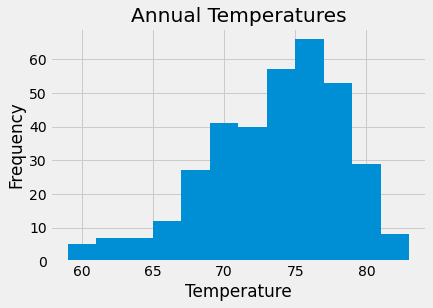

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = engine.execute('SELECT tobs FROM measurement WHERE station = "USC00519281"\
                        AND date >= "2016-08-23"').fetchall()
df = pd.DataFrame(temp, columns = ['Annual Temperatures'])
df.hist(column = 'Annual Temperatures', bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

# Close session

In [40]:
# Close Session
session.close()